In this part, we will focus on building a model for the predicate of sales in store 1 for product 1.
We will experiment with Deep Learning models like LSTM using PyTorch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
path = "data/"
df = pd.read_csv(path + 'train.csv.zip', compression='zip')
df['date'] = pd.to_datetime(df['date'])
print(f'Data column type: {df['date'].dtype}')
df = df.set_index('date')
df.iloc[:10]

Data column type: datetime64[ns]


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


Let's focus on one store and one product.  
  We will select a subset of the data that corresponds to the sales of the item with `item == 1` in the store with `store == 1`.

In [3]:
df_11 = df[(df['store'] == 1) & (df['item'] == 1)]  
print(df_11.item.value_counts(), df_11.store.value_counts())
df_11.head()

item
1    1826
Name: count, dtype: int64 store
1    1826
Name: count, dtype: int64


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [4]:
# convert the sales column to float as NN requires float
sale_counts = df_11['sales'].values.astype(float)

Divide the data into training and validation as 80% to 20%

In [5]:
split_point = int(len(sale_counts) * 0.8)
train, test = sale_counts[:split_point], sale_counts[split_point:]

print(f'Train shape: {train.shape}, Test shape: {test.shape}')

Train shape: (1460,), Test shape: (366,)


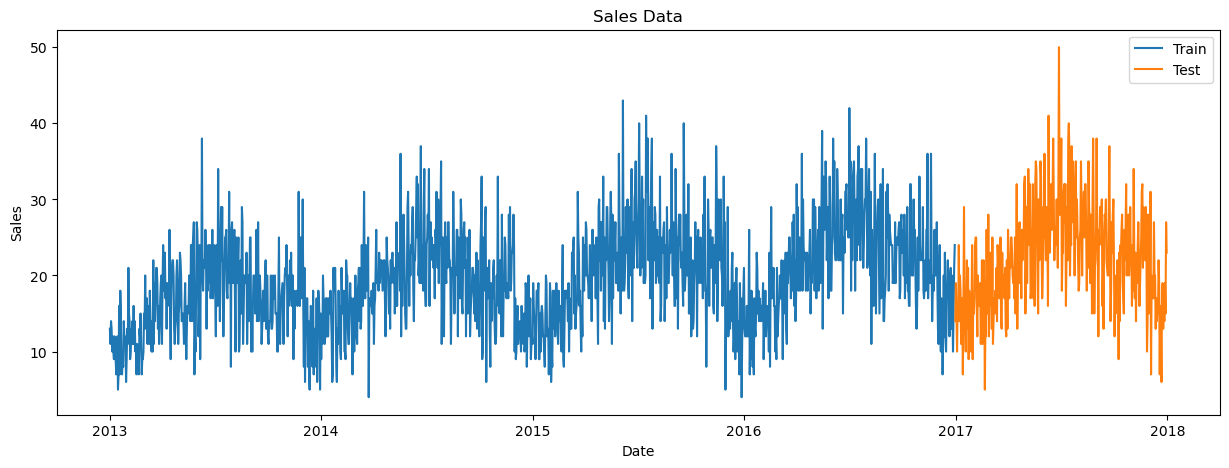

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df_11.index[:split_point], train, label='Train')   
plt.plot(df_11.index[split_point:], test, label='Test')

plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Model Preparation 

In [ ]:
import torch

def create_dataset(data, lookback):
    """
    Create a dataset for time series forecasting.
    Args:
        data (array-like): The time series data.
        lookback (int): The number of previous time steps to use as input.
    Returns:
        X (torch.Tensor): The input data of shape (num_samples, lookback).
        y (torch.Tensor): The target data of shape (num_samples,).
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return torch.tensor(X), torch.tensor(y)   


def train_model(model, train_loader, test_loader, optimizer, mse, num_epochs, patience=10):
    """
    Train the model and print the train and test loss every 100 epochs.
    """
    best_mape = float('inf')
    patience_counter = 0

    total_train_loss = []
    total_mape_train = []
    total_mape_test = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        # Iterate over the training data
        for X_batch, y_batch in train_loader:
            model.train()
            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = mse(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        # Calculate average loss for the epoch    
        total_train_loss.append(epoch_loss / len(train_loader))

        # use evaluate mode to avoid updating the weights
        model.eval()                   
        with torch.no_grad():
            # Calculate MAPE for train and test sets
            train_pred = model(X_train)
            test_pred = model(X_test)
            train_mape = mean_absolute_percentage_error(y_train, train_pred)
            test_mape = mean_absolute_percentage_error(y_test, test_pred)
            
            total_mape_train.append(train_mape)
            total_mape_test.append(test_mape)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")
                
            # Early stopping check
            if test_mape < best_mape:
                best_mape = test_mape
                patience_counter = 0
                
                #save the best model
                torch.save(model.state_dict(), 'best_model.pt')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best test MAPE: {best_mape:.4f}")
                break    

    return total_train_loss, total_mape_train, total_mape_test


class AirModel (nn.Module):
    """
    A simple LSTM model for time series forecasting.
    """
    def __init__ (self, hidden_size, num_layers, bidirectional=False):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=1, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers, 
                            bidirectional=bidirectional, 
                            batch_first=True)
        
        # Adjust the input size of the fully connected layer based on bidirectionality        
        fc_input_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(fc_input_size, 1)
        
    def forward(self, x):
        x = x.unsqueeze(-1)  # shape: [batch_size, seq_len, 1]
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)   # shape: [batch_size, 1]
        return out.squeeze(-1)  # shape: [batch_size]

In [8]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)  
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1453, 7]) torch.Size([1453])
torch.Size([359, 7]) torch.Size([359])


In [9]:
BATCH_SIZE = 16

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataloader first batch preview: {next(iter(train_loader))}") 

Train dataloader first batch preview: [tensor([[11., 28., 17., 27., 22., 24., 27.],
        [17., 16., 13., 13., 23., 21., 24.],
        [28., 24., 28., 22., 21., 23., 19.],
        [ 6., 13., 11., 18., 13., 16., 10.],
        [17., 17., 20., 15., 15., 15., 10.],
        [20., 19., 19., 27., 19., 23., 25.],
        [11.,  7.,  9.,  9., 10., 15., 13.],
        [27., 18., 27., 20., 22., 33., 14.],
        [20., 26., 20., 25., 22., 19., 33.],
        [20., 18., 26., 20., 20., 22., 27.],
        [26., 22., 12., 15., 24.,  9., 21.],
        [29., 12., 14., 14., 13., 18., 14.],
        [19., 10., 17., 16., 13., 13., 23.],
        [25., 33., 26., 28., 35., 32., 22.],
        [19., 17., 11., 29., 30., 22., 27.],
        [19., 23., 11., 16., 20., 14., 20.]]), tensor([19., 25., 16.,  9., 10., 25., 20., 25., 14., 19., 20., 21., 21., 26.,
        18., 25.])]


In [23]:
HIDDEN_SIZE = 50
NUM_LAYERS = lookback

model = AirModel(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)

mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


AirModel(
  (lstm): LSTM(1, 50, num_layers=7, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [24]:
NUM_EPOCHS = 500

train_loss, MAPE_train, MAPE_test = train_model(model, train_loader, test_loader, optimizer, mse, num_epochs=NUM_EPOCHS, patience=3)

Epoch 0, Train MAPE: 0.5371, Test MAPE: 0.5991
Epoch 10, Train MAPE: 0.3318, Test MAPE: 0.2831
Epoch 20, Train MAPE: 0.3304, Test MAPE: 0.2830
Epoch 30, Train MAPE: 0.2816, Test MAPE: 0.2454
Epoch 40, Train MAPE: 0.2450, Test MAPE: 0.2322
Epoch 50, Train MAPE: 0.2370, Test MAPE: 0.2293
Epoch 60, Train MAPE: 0.2301, Test MAPE: 0.2203
Epoch 70, Train MAPE: 0.2504, Test MAPE: 0.2379
Epoch 80, Train MAPE: 0.2351, Test MAPE: 0.2258
Epoch 90, Train MAPE: 0.2296, Test MAPE: 0.2242
Early stopping triggered at epoch 90. Best test MAPE: 0.2203


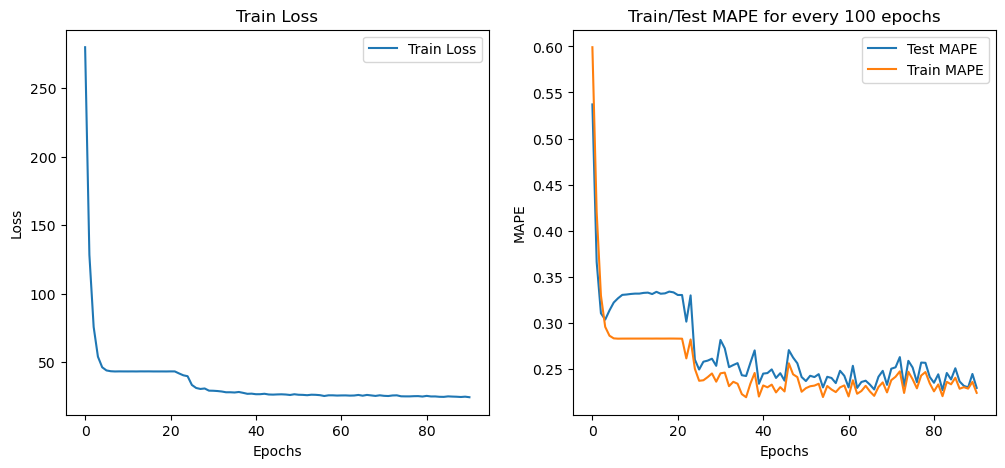

In [25]:
def plot_loss(train_loss, MAPE_train, MAPE_test):
    """
    Plot the train loss and test MAPE.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(MAPE_train, label='Test MAPE')
    plt.plot(MAPE_test, label='Train MAPE')
    plt.title('Train/Test MAPE for every 100 epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()

plot_loss(train_loss, MAPE_train, MAPE_test)

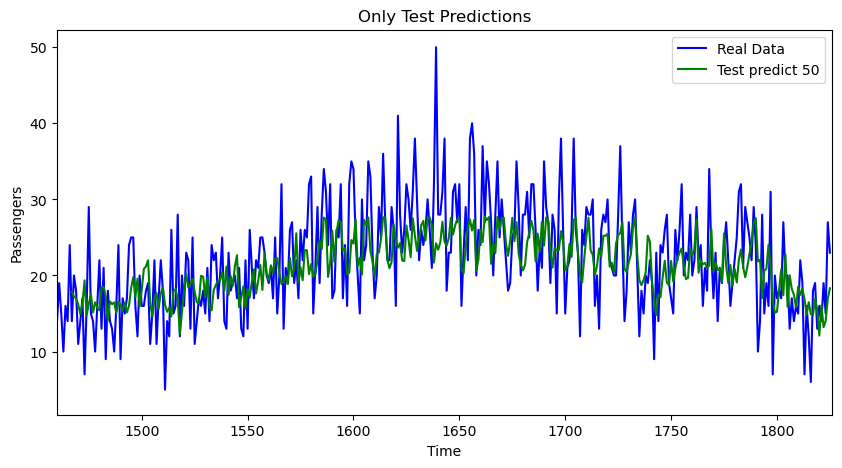

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

with torch.no_grad():
      train_size = len(train)
      # shift predictions for train data
      train_plot = np.ones_like(sale_counts) * np.nan
      y_pred = model(X_train)
      train_plot[lookback:train_size] = model(X_train)

      # shift predictions for test data
      test_plot = np.ones_like(sale_counts) * np.nan
      test_plot[train_size+lookback:len(sale_counts)] = model(X_test)

plt.figure(figsize=(10, 5))
plt.plot(sale_counts, c='b', label = "Real Data ") 
plt.plot(test_plot, c='g', label = "Test predict 50")   

plt.xlim(train_size, len(sale_counts))
plt.title('Only Test Predictions')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()

We will also launch a bi-directional LSTM to try to improve the accuracy of the forecast

In [10]:
HIDDEN_SIZE = 50
NUM_LAYERS = 1
NUM_EPOCHS = 500

model_bidirect = AirModel(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)

mse = nn.MSELoss()
optimizer = optim.Adam(model_bidirect.parameters(), lr=0.001)

print(model_bidirect)

train_loss_bidirect, MAPE_train_bidirect, MAPE_test_bidirect = train_model(model_bidirect, train_loader, test_loader, optimizer, mse, num_epochs=NUM_EPOCHS, patience=5)
# plot_loss(train_loss_bidirect, MAPE_train_bidirect, MAPE_test_bidirect)


AirModel(
  (lstm): LSTM(1, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Epoch 0, Train MAPE: 0.5570, Test MAPE: 0.6137
Epoch 10, Train MAPE: 0.2432, Test MAPE: 0.2321
Epoch 20, Train MAPE: 0.2444, Test MAPE: 0.2324
Epoch 30, Train MAPE: 0.2478, Test MAPE: 0.2341
Epoch 40, Train MAPE: 0.2453, Test MAPE: 0.2338
Epoch 50, Train MAPE: 0.2405, Test MAPE: 0.2298
Epoch 60, Train MAPE: 0.2463, Test MAPE: 0.2346
Epoch 70, Train MAPE: 0.2302, Test MAPE: 0.2223
Epoch 80, Train MAPE: 0.2391, Test MAPE: 0.2288
Epoch 90, Train MAPE: 0.2349, Test MAPE: 0.2268
Epoch 100, Train MAPE: 0.2379, Test MAPE: 0.2271
Epoch 110, Train MAPE: 0.2354, Test MAPE: 0.2313
Epoch 120, Train MAPE: 0.2294, Test MAPE: 0.2247
Early stopping triggered at epoch 120. Best test MAPE: 0.2223


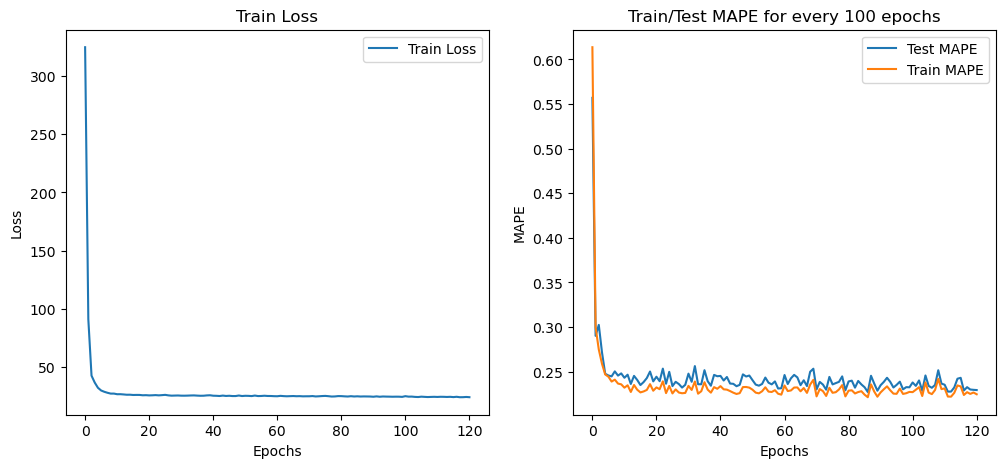

In [13]:
plot_loss(train_loss_bidirect, MAPE_train_bidirect, MAPE_test_bidirect)

We created an LSTM network and the number of hidden layers of 50 showed the best result (the model quickly retrains when adding more layers)
- Also, to minimize overfitting, we implemented an early stop function that will stop training if the quality of the model deteriorates after a certain number of epochs.
- Based on the previous data analysis, we determined that the following values are the predictions based on the past 7 sales values (weekly seasonality)
- In general, our LSTM achieved the better performance as the XGB. 
- The bidirectional network did not outperform the standard LSTM, but it became slightly better than the classic XGB
    - **XGB with covariates** MAPE = 22.77
    - **LSTM** MAPE  = 22.03
    - **Bi-LSTM** MAPE = 22.23
